# Brewing Logistic Regression then Going Deeper

While Caffe is made for deep networks it can likewise represent "shallow" models like logistic regression for classification. We'll do simple logistic regression on synthetic data that we'll generate and save to HDF5 to feed vectors to Caffe. Once that model is done, we'll add layers to improve accuracy. That's what Caffe is about: define a model, experiment, and then deploy.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir('.')

import sys
sys.path.insert(0, '../python')
import caffe


import os
import h5py
import shutil
import tempfile

import sklearn
import sklearn.datasets
import sklearn.linear_model

import pandas as pd

Synthesize a dataset of 10,000 4-vectors for binary classification with 2 informative features and 2 noise features.

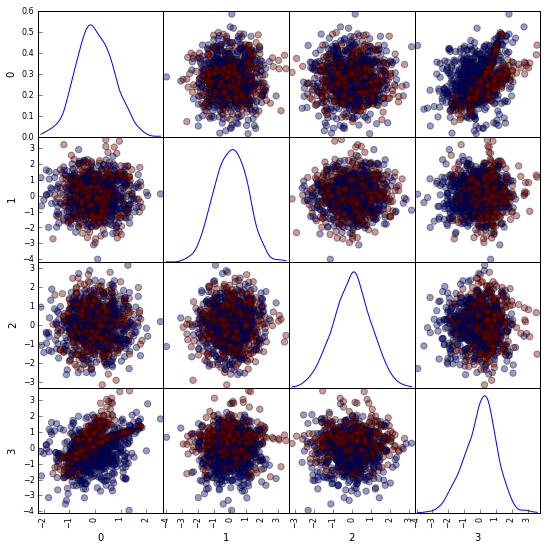

In [8]:
X, y = sklearn.datasets.make_classification(
    n_samples=10000, n_features=4, n_redundant=0, n_informative=2, 
    n_clusters_per_class=2, hypercube=False, random_state=0
)

# Split into train and test
X, Xt, y, yt = sklearn.cross_validation.train_test_split(X, y)

# Visualize sample of the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.scatter_matrix(df, figsize=(9, 9), diagonal='kde', marker='o', s=40, alpha=.4, c=y[ind])

Learn and evaluate scikit-learn's logistic regression with stochastic gradient descent (SGD) training. Time and check the classifier's accuracy.

In [9]:
%%time
# Train and test the scikit-learn SGD logistic regression.
clf = sklearn.linear_model.SGDClassifier(
    loss='log', n_iter=1000, penalty='l2', alpha=1e-3, class_weight='auto')

clf.fit(X, y)
yt_pred = clf.predict(Xt)
print('Accuracy: {:.3f}'.format(sklearn.metrics.accuracy_score(yt, yt_pred)))

Accuracy: 0.772
CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 550 ms


Save the dataset to HDF5 for loading in Caffe.

In [10]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
dirname = os.path.abspath('./hdf5_classification/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')
    
# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')

Learn and evaluate logistic regression in Caffe.

In [11]:
%%time
caffe.set_mode_cpu()
solver = caffe.get_solver('hdf5_classification/solver.prototxt')
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.772
CPU times: user 981 ms, sys: 4.33 s, total: 5.31 s
Wall time: 722 ms


Do the same through the command line interface for detailed output on the model and solving.

In [12]:
!../build/tools/caffe train -solver hdf5_classification/solver.prototxt

I0318 03:28:34.839617 17071 caffe.cpp:117] Use CPU.
I0318 03:28:34.989301 17071 caffe.cpp:121] Starting Optimization
I0318 03:28:34.989439 17071 solver.cpp:32] Initializing solver from parameters: 
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "hdf5_classification/data/train"
solver_mode: CPU
net: "hdf5_classification/train_val.prototxt"
I0318 03:28:34.989524 17071 solver.cpp:70] Creating training net from net file: hdf5_classification/train_val.prototxt
I0318 03:28:34.989789 17071 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0318 03:28:34.989814 17071 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0318 03:28:34.989871 17071 net.cpp:42] Initializing net from parameters: 
name: "LogisticRegressionNet"
state {
  phase: TRAIN
}
layer {
  

If you look at output or the `train_val.prototxt`, you'll see that the model is simple logistic regression.
We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer network.
That network is given in `train_val2.prototxt`, and that's the only change made in `solver2.prototxt` which we will now use.

The final accuracy of the new network be higher than logistic regression!

In [13]:
%%time
caffe.set_mode_cpu()
solver = caffe.get_solver('hdf5_classification/solver2.prototxt')
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.831
CPU times: user 1.29 s, sys: 5.76 s, total: 7.06 s
Wall time: 947 ms


Do the same through the command line interface for detailed output on the model and solving.

In [14]:
!../build/tools/caffe train -solver hdf5_classification/solver2.prototxt

I0318 03:28:39.104432 17088 caffe.cpp:117] Use CPU.
I0318 03:28:39.256731 17088 caffe.cpp:121] Starting Optimization
I0318 03:28:39.256882 17088 solver.cpp:32] Initializing solver from parameters: 
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "hdf5_classification/data/train"
solver_mode: CPU
net: "hdf5_classification/train_val2.prototxt"
I0318 03:28:39.256973 17088 solver.cpp:70] Creating training net from net file: hdf5_classification/train_val2.prototxt
I0318 03:28:39.257277 17088 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0318 03:28:39.257305 17088 net.cpp:257] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0318 03:28:39.257400 17088 net.cpp:42] Initializing net from parameters: 
name: "LogisticRegressionNet"
state {
  phase: TRAIN
}
layer {


In [15]:
# Clean up (comment this out if you want to examine the hdf5_classification/data directory).
shutil.rmtree(dirname)